# Pull Request Acceptance Prediction Using Machine Learning

## Objective
This project builds and evaluates machine learning models to predict whether a Pull Request (PR) will be accepted based on repository metadata, PR structure features, and categorical attributes such as agent and programming language.

The goal is not only to build a predictive model, but also to:

- Compare multiple model families (Logistic Regression vs Random Forest)
- Evaluate multiple hyperparameter variants
- Use several evaluation metrics beyond ROC-AUC
- Test model stability and threshold behavior
- Check for baseline and subgroup bias
- Interpret feature influence using coefficients and importances

This notebook demonstrates:
- Research understanding
- Experimental model comparison
- Careful metric interpretation
- Bias and robustness checks


In [5]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm
from scipy.stats import mannwhitneyu, chi2_contingency
from sklearn.model_selection import StratifiedKFold, cross_val_score, train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import (roc_auc_score, accuracy_score, precision_score,recall_score, f1_score, average_precision_score, roc_curve)
from sklearn.ensemble import RandomForestClassifier
from sklearn.utils import resample

In [6]:
all_pr_df = pd.read_parquet("hf://datasets/hao-li/AIDev/all_pull_request.parquet")
all_repo_df = pd.read_parquet("hf://datasets/hao-li/AIDev/all_repository.parquet")
all_user_df = pd.read_parquet("hf://datasets/hao-li/AIDev/all_user.parquet")
print(all_pr_df.shape)
print(all_repo_df.shape)
print(all_user_df.shape)

all_pr_df.head(3)

(932791, 14)
(116211, 7)
(72189, 5)


,id,number,title,body,agent,user_id,user,state,created_at,closed_at,merged_at,repo_id,repo_url,html_url
0,3264016139,1688,`metta code` --> `metta clip` and additional p...,Remove unused `root_key` variable to fix ruff ...,Claude_Code,37011,jacklionheart,closed,2025-07-25T18:15:36Z,2025-07-25T19:17:23Z,2025-07-25T19:17:23Z,843988367.0,https://api.github.com/repos/Metta-AI/metta,https://github.com/Metta-AI/metta/pull/1688
1,3264021033,41,feat: Comprehensive ruff error resolution with...,## 🎯 Mission Accomplished: 100% Ruff Error Res...,Claude_Code,131842369,Draco3310,open,2025-07-25T18:17:57Z,NaN,NaN,992063465.0,https://api.github.com/repos/Draco3310/Gal-Fri...,https://github.com/Draco3310/Gal-Friday2/pull/41
2,3264042289,1600,Add Evals frontend implementation plan and HTM...,\nCreate comprehensive implementation plan for...,Claude_Code,6766889,justicart,closed,2025-07-25T18:26:15Z,2025-07-25T23:19:14Z,NaN,926711750.0,https://api.github.com/repos/bolt-foundry/bolt...,https://github.com/bolt-foundry/bolt-foundry/p...


#### Dataset Description

The dataset contains Pull Request level observations with:

**Target variable**
- `accepted` - whether the PR was accepted (binary classification target)

**Feature groups**
- PR metadata (title length, body existence, etc.)
- Repository popularity signals (followers, stars — log transformed)
- Agent source (AI or tool used to generate PR)
- Programming language
- Structural PR features

Categorical variables are later one-hot encoded.  
One category is dropped per group to serve as a **baseline reference level** for model interpretation.


In [7]:
pr = all_pr_df.copy()
repo = all_repo_df.copy()
user = all_user_df.copy()

--------------------------------------------------------------------------------------------------------------------------------------------------

#### Why Use Only Creation-Time Signals?

I've intentionally restricted features to those available when a PR is opened. This avoids data leakage and ensures the model simulates a real decision-support tool.

Review outcomes, comments, and later activity are excluded because they occur after the prediction point.


In [8]:
pr["accepted"] = pr["merged_at"].notna().astype(int)


In [9]:
pr["title_len"] = pr["title"].str.len()
pr["has_body"] = pr["body"].notna().astype(int)

pr["created_at"] = pd.to_datetime(pr["created_at"])
pr["created_hour"] = pr["created_at"].dt.hour
pr["created_weekday"] = pr["created_at"].dt.weekday


| Feature   | Why                      |
| --------- | ------------------------ |
| title_len | description effort proxy |
| has_body  | documentation presence   |
| hour      | review timing effects    |
| weekday   | workflow cycles          |


### Why would title length matter?
Title length is not a causal factor but a proxy for PR description quality and specificity. In practice, more descriptive titles tend to accompany clearer, better-scoped pull requests, which reviewers can evaluate more easily. The model detects this statistical pattern and uses it as a predictive signal.

Longer title length DOES NOT mean that it is more likely to be accepted

In [10]:
repo_small = repo[["id","stars","forks","language"]]
pr = pr.merge(repo_small, left_on="repo_id", right_on="id", how="left")


In [11]:
user_small = user[["id","followers"]]
pr = pr.merge(user_small, left_on="user_id", right_on="id", how="left")


In [12]:
pr["log_stars"] = np.log1p(pr["stars"])
pr["log_followers"] = np.log1p(pr["followers"])

#### Why Log Transform?

Repository stars and user followers follow heavy-tailed distributions. Log transformation compresses extreme values and improves model stability compared to raw scale.


#### Why Repo Stars but not forks as main signal?
Repo maturity --> stricter review --> acceptance impact. Forks measure reuse, not governance strictness.

#### Why Followers?
Having reputation proxies means the reviewer tend to trust more

In [13]:
features = [
    "title_len",
    "has_body",
    "created_hour",
    "created_weekday",
    "log_stars",
    "log_followers",
    "agent",
    "language"
]

df = pr[features + ["accepted"]].dropna()

I've combined the data from repo and user datasheet into PR by matching the ID of the account and the project related. 

I've also only use signals available at PR creation time to avoid label leakage and ensure deployable prediction.

List of excluded features:
- review count
- turnaround time
- review comments
- commit stats after merge

#### Baseline Category in One-Hot Encoding

One category will be dropped per categorical variable to avoid multicollinearity. The dropped category becomes the baseline reference for coefficient interpretation.

Changing the baseline affects coefficient values but does not change predictions which we will verify this later.


In [14]:
baseline_info = {}

baseline_info["agent_baseline"] = sorted(df["agent"].dropna().unique())[0]
baseline_info["language_baseline"] = sorted(df["language"].dropna().unique())[0]

print("Agent baseline:", baseline_info["agent_baseline"])
print("Language baseline:", baseline_info["language_baseline"])


Agent baseline: Claude_Code
Language baseline: 1C Enterprise


In [15]:
df_before_dummies = df.copy()

In [16]:
df = pd.get_dummies(df, columns=["agent","language"], drop_first=True)
print(df["accepted"].head())


0    1
1    0
2    0
3    0
4    1
Name: accepted, dtype: int32


In [17]:
df_after_dummies = df.copy()

In [18]:
def find_baselines(original_df, encoded_df, cols):
    baselines = {}
    for c in cols:
        orig_vals = sorted(original_df[c].dropna().unique())
        dummy_cols = [col for col in encoded_df.columns if col.startswith(c+"_")]
        present = [col.split("_",1)[1] for col in dummy_cols]
        dropped = sorted(set(orig_vals) - set(present))
        baselines[c] = dropped
    return baselines

baseline_info = find_baselines(df_before_dummies, df_after_dummies, ["agent","language"])

print("Baseline categories used:")
for k,v in baseline_info.items():
    print(f"{k}: {v}")


Baseline categories used:
agent: ['Claude_Code']
language: ['1C Enterprise']


In [19]:
X = df.drop("accepted", axis=1)
y = df["accepted"]

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=42
)


In [20]:
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)


### Model Variants and Hyperparameter Sensitivity
Multiple Logistic Regression and Random Forest variants will be trained with different hyperparameters to verify that results are stable and not dependent on a single configuration.


#### Logistic Regression - Model Variants

We train multiple Logistic Regression variants by adjusting:

- Regularization strength (C)
- Regularization type (L1 vs L2)
- Solver choice
- Class balancing

#### Why multiple variants?

Logistic regression is sensitive to:
- Regularization strength
- Feature sparsity
- Class imbalance

Testing variants helps verify:
- Stability of ranking
- Sensitivity to hyperparameters
- Robustness of conclusions


In [21]:
lr_configs = [
    ("LR_default", dict(max_iter=1000)),

    ("LR_strong_reg", dict(C=0.1, max_iter=1000)),
    ("LR_weak_reg", dict(C=5.0, max_iter=1000)),

    ("LR_L1", dict(penalty="l1", solver="liblinear", max_iter=1000)),
    ("LR_balanced", dict(class_weight="balanced", max_iter=1000)),

    ("LR_liblinear", dict(solver="liblinear", max_iter=1000)),
]

lr_rows = []
lr_models = {} 

for name, params in lr_configs:

    model = LogisticRegression(**params)
    model.fit(X_train_scaled, y_train)

    lr_models[name] = model

    prob = model.predict_proba(X_test_scaled)[:,1]
    pred = model.predict(X_test_scaled)

    lr_rows.append({
        "model": name,
        "ROC_AUC": roc_auc_score(y_test, prob),
        "PR_AUC": average_precision_score(y_test, prob),
        "Accuracy": accuracy_score(y_test, pred),
        "Precision": precision_score(y_test, pred),
        "Recall": recall_score(y_test, pred),
        "F1": f1_score(y_test, pred),
    })

lr_results = pd.DataFrame(lr_rows).sort_values("ROC_AUC", ascending=False)
lr_results

c:\Users\itm\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\linear_model\_logistic.py:1135: FutureWarning: 'penalty' was deprecated in version 1.8 and will be removed in 1.10. To avoid this warning, leave 'penalty' set to its default value and use 'l1_ratio' or 'C' instead. Use l1_ratio=0 instead of penalty='l2', l1_ratio=1 instead of penalty='l1', and C=np.inf instead of penalty=None.
  warnings.warn(
c:\Users\itm\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\linear_model\_logistic.py:1160: UserWarning: Inconsistent values: penalty=l1 with l1_ratio=0.0. penalty is deprecated. Please use l1_ratio only.
  warnings.warn(


,model,ROC_AUC,PR_AUC,Accuracy,Precision,Recall,F1
4,LR_balanced,0.608115,0.904561,0.695275,0.897348,0.734970,0.808083
2,LR_weak_reg,0.607702,0.904388,0.872663,0.873668,0.998501,0.931922
0,LR_default,0.607702,0.904388,0.872663,0.873668,0.998501,0.931922
1,LR_strong_reg,0.607702,0.904388,0.872657,0.873663,0.998501,0.931919
3,LR_L1,0.607702,0.904396,0.872663,0.873663,0.998507,0.931923
5,LR_liblinear,0.607701,0.904394,0.872663,0.873668,0.998501,0.931922


for Random Forest, we need to split the data down in size or else the training time would be too long

In [22]:
X_train_small, y_train_small = resample(
    X_train, y_train,
    n_samples=int(len(X_train)*0.25),
    random_state=42,
    stratify=y_train
)


#### Random Forest - Model Variants

Random Forest models are trained with multiple hyperparameter settings:

- Number of trees
- Tree depth
- Leaf smoothing
- Class weighting

Why this matters:

Random Forest can:
- Capture nonlinear relationships
- Handle interactions automatically
- Be more robust to scaling

But it is slower and can overfit - so we compare shallow vs deep vs balanced variants.


In [23]:
rf_configs = [
    ("RF_default", dict(n_estimators=200, random_state=42)),

    ("RF_more_trees", dict(n_estimators=400, random_state=42)),

    ("RF_shallow", dict(n_estimators=200, max_depth=6, random_state=42)),

    ("RF_deep", dict(n_estimators=200, max_depth=None, random_state=42)),

    ("RF_leaf_smooth", dict(n_estimators=200, min_samples_leaf=5, random_state=42)),

    ("RF_balanced", dict(n_estimators=200, class_weight="balanced", random_state=42)),
]

rf_rows = []
rf_models = {}

for name, params in rf_configs:
    model = RandomForestClassifier(**params)
    model.fit(X_train_small, y_train_small) 

    rf_models[name] = model 

    prob = model.predict_proba(X_test)[:,1]
    pred = model.predict(X_test)

    rf_rows.append({
        "model": name,
        "ROC_AUC": roc_auc_score(y_test, prob),
        "PR_AUC": average_precision_score(y_test, prob),
        "Accuracy": accuracy_score(y_test, pred),
        "Precision": precision_score(y_test, pred),
        "Recall": recall_score(y_test, pred),
        "F1": f1_score(y_test, pred),
    })

rf_results = pd.DataFrame(rf_rows).sort_values("ROC_AUC", ascending=False)



In [24]:
# Store probability outputs for every model
model_probs = {}

for name, model in lr_models.items():
    model_probs[name] = model.predict_proba(X_test_scaled)[:, 1]

for name, model in rf_models.items():
    model_probs[name] = model.predict_proba(X_test)[:, 1]

print("Stored probability outputs for:", list(model_probs.keys()))

Stored probability outputs for: ['LR_default', 'LR_strong_reg', 'LR_weak_reg', 'LR_L1', 'LR_balanced', 'LR_liblinear', 'RF_default', 'RF_more_trees', 'RF_shallow', 'RF_deep', 'RF_leaf_smooth', 'RF_balanced']


#### Why ROC AUC Is the Primary Metric?

ROC AUC measures ranking quality independent of threshold and is robust to class imbalance. It is used to compare model families fairly.

Threshold-dependent metrics such as Precision, Recall, F1 are analyzed separately for deployment tuning.


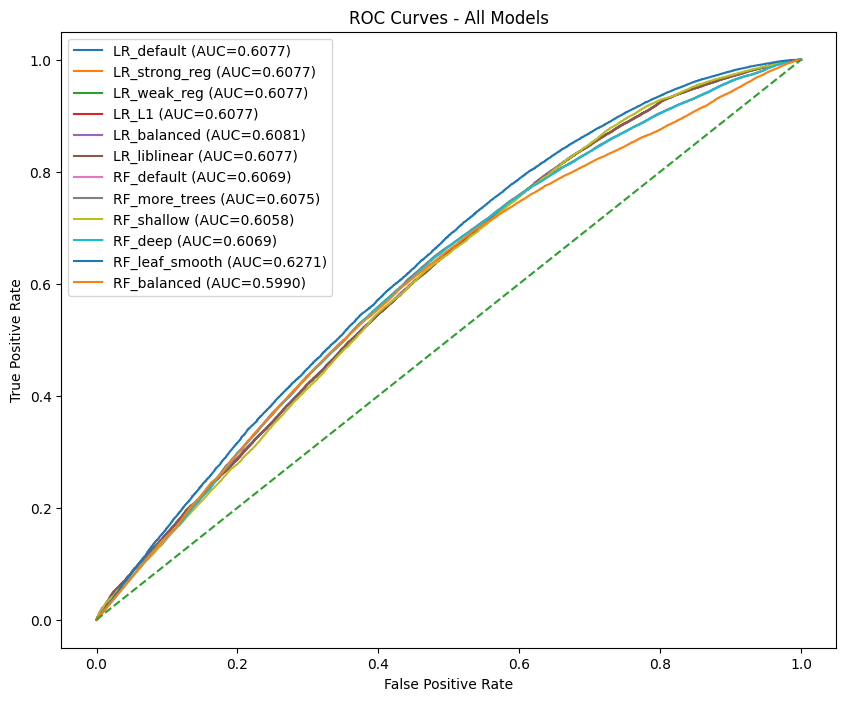

In [25]:
plt.figure(figsize=(10,8))

for name, prob in model_probs.items():
    fpr, tpr, _ = roc_curve(y_test, prob)
    score = roc_auc_score(y_test, prob)
    plt.plot(fpr, tpr, label=f"{name} (AUC={score:.4f})")

plt.plot([0,1],[0,1], linestyle="--")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curves - All Models")
plt.legend()
plt.show()


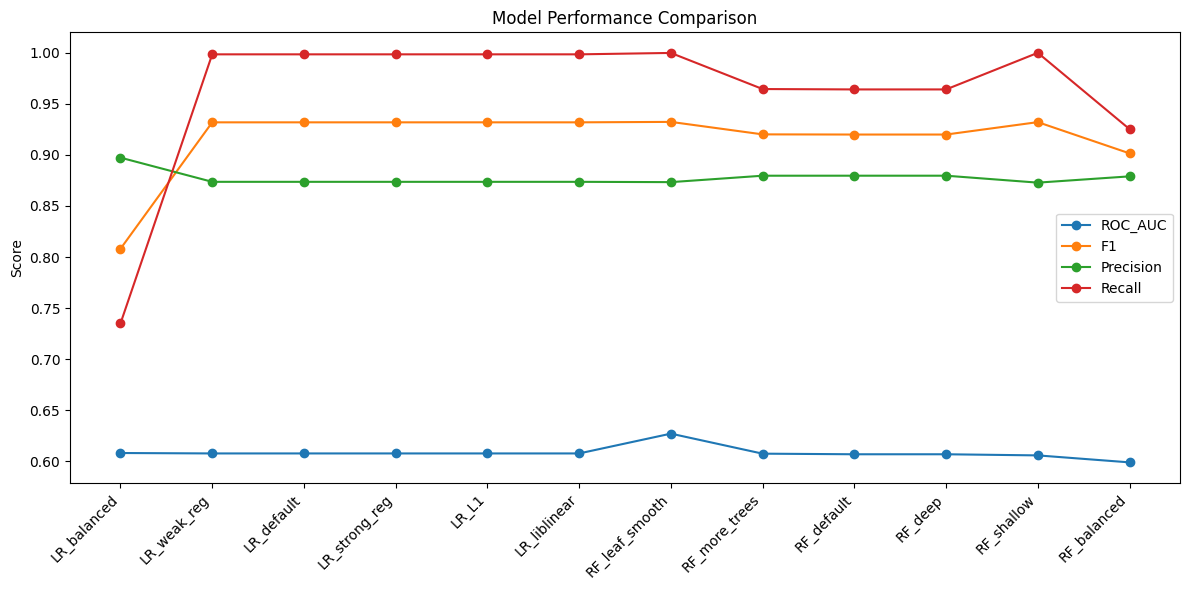

In [26]:
all_results = pd.concat([
    lr_results.assign(type="Logistic"),
    rf_results.assign(type="RandomForest")
])

plt.figure(figsize=(12,6))

for metric in ["ROC_AUC","F1","Precision","Recall"]:
    plt.plot(all_results["model"], all_results[metric], marker="o", label=metric)

plt.xticks(rotation=45, ha="right")
plt.ylabel("Score")
plt.title("Model Performance Comparison")
plt.legend()
plt.tight_layout()
plt.show()



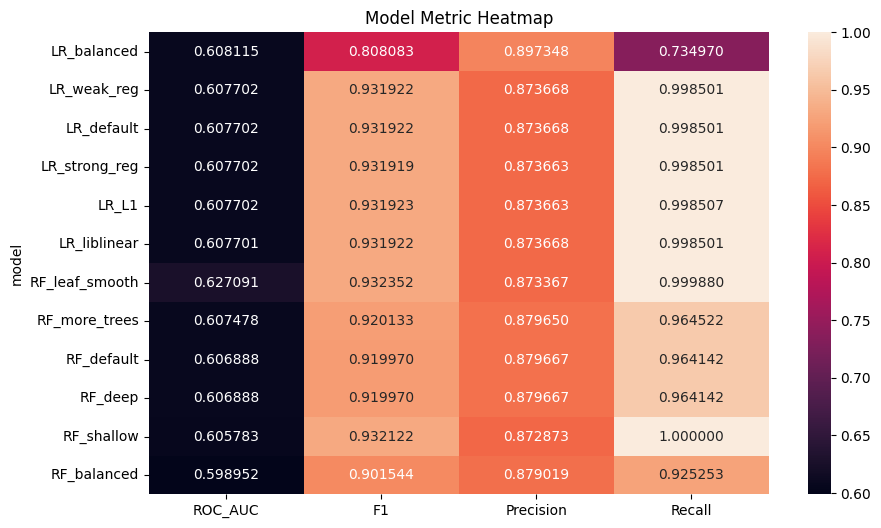

In [27]:
plt.figure(figsize=(10,6))
sns.heatmap(
    all_results.set_index("model")[["ROC_AUC","F1","Precision","Recall"]],
    annot=True,
    fmt=".6f"
)
plt.title("Model Metric Heatmap")
plt.show()


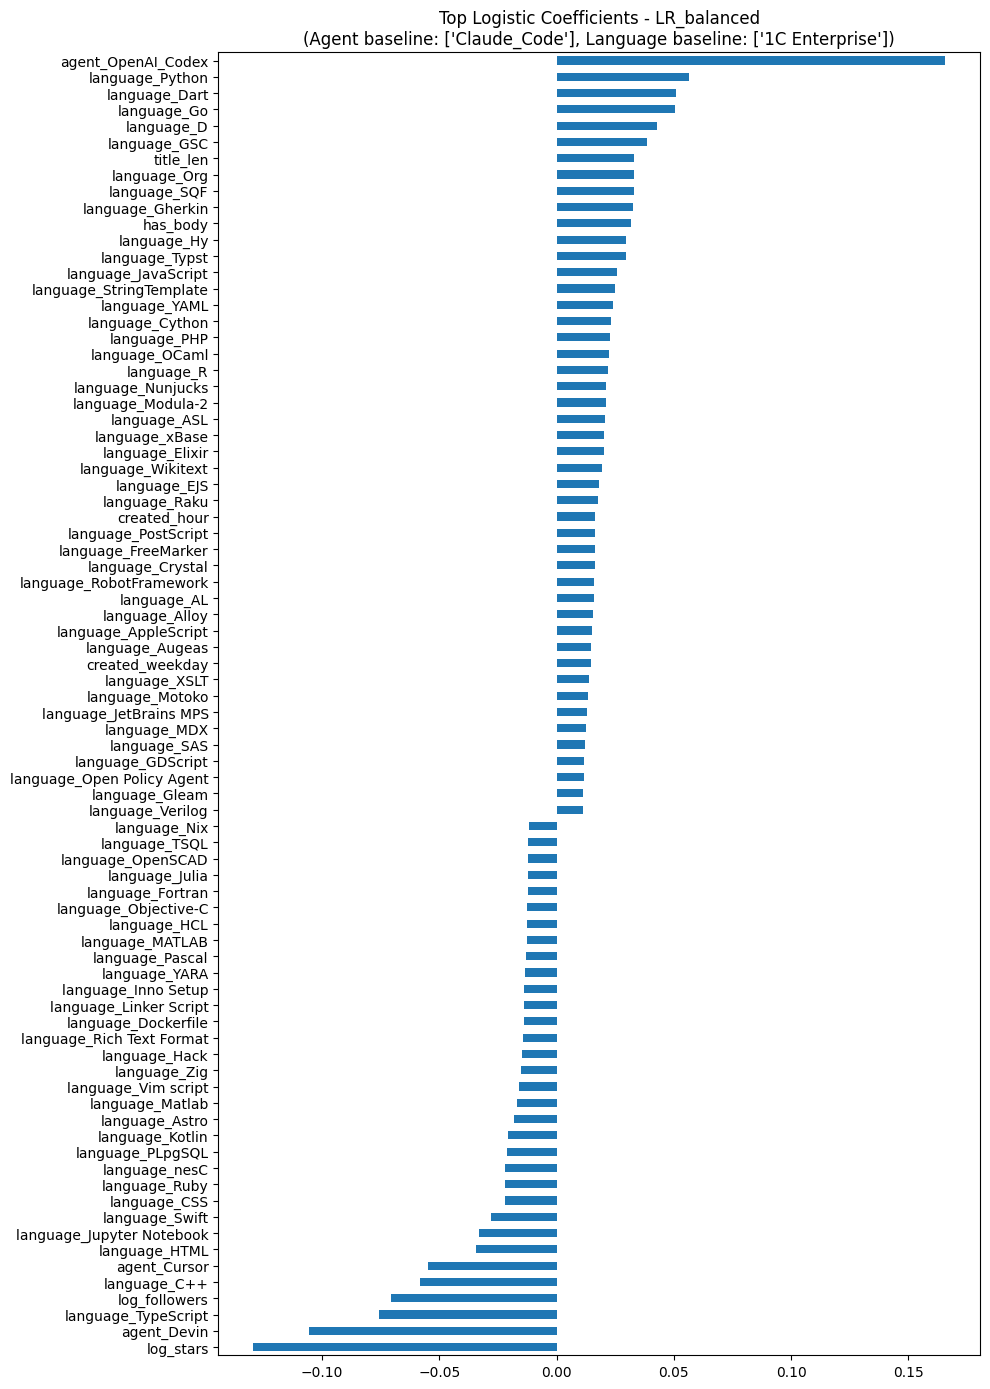

In [28]:
best_lr_name = lr_results.iloc[0]["model"]
best_lr = lr_models[best_lr_name]

coef = pd.Series(best_lr.coef_[0], index=X.columns)

top = coef.abs().sort_values(ascending=False).head(80).index
coef_top = coef.loc[top].sort_values()

plt.figure(figsize=(10,14))
coef_top.plot.barh()
plt.title(
    f"Top Logistic Coefficients - {best_lr_name}\n"
    f"(Agent baseline: {baseline_info['agent']}, "
    f"Language baseline: {baseline_info['language']})"
)
plt.tight_layout()
plt.show()


In [ ]:
coef_full = pd.Series(best_lr.coef_[0], index=X.columns)

print(coef_full[["created_hour","created_weekday"]])
#sanity check for specific number of specific feature

created_hour       0.016322
created_weekday    0.014559
dtype: float64


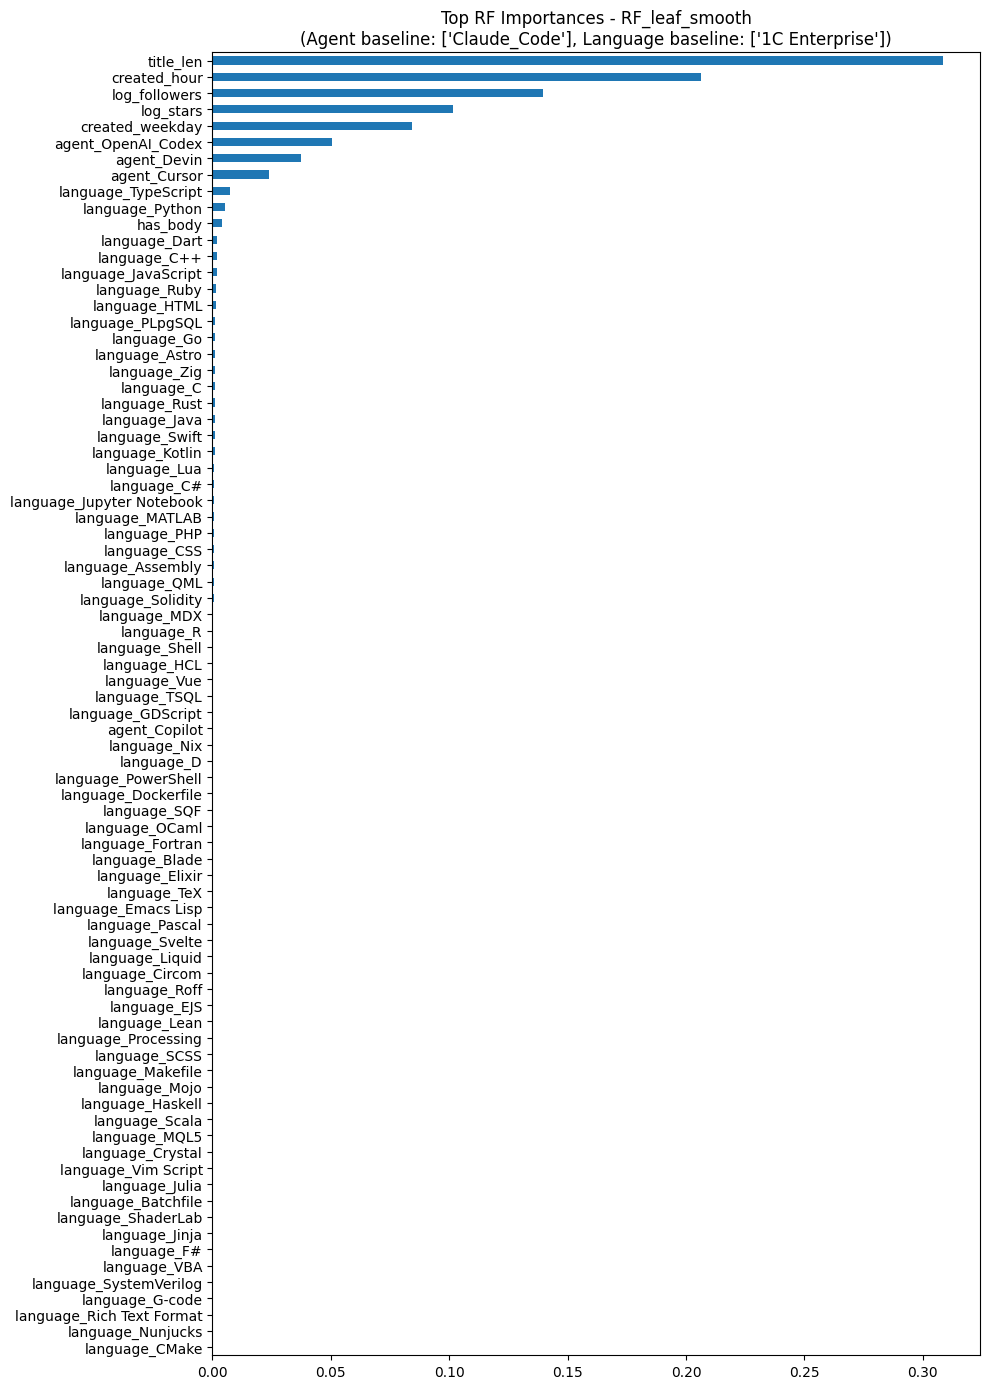

In [30]:
best_rf_name = rf_results.iloc[0]["model"]
best_rf = rf_models[best_rf_name]

imp = pd.Series(best_rf.feature_importances_, index=X.columns)

top = imp.sort_values(ascending=False).head(80).sort_values()

plt.figure(figsize=(10,14))
top.plot.barh()
plt.title(
    f"Top RF Importances - {best_rf_name}\n"
    f"(Agent baseline: {baseline_info['agent']}, "
    f"Language baseline: {baseline_info['language']})"
)
plt.tight_layout()
plt.show()


The feature importance visualizations help explain which early pull request signals most influence acceptance prediction. 

The **logistic regression** coefficients show both the direction and strength of each feature’s effect. Positive coefficients indicate that a feature increases the probability of acceptance, while negative coefficients indicate a higher likelihood of rejection. This allows us to interpret how factors such as repository popularity, PR description presence, and agent type influence outcomes.

The **random forest importance** plot complements this by showing the relative predictive power of each feature in a nonlinear model. Unlike logistic regression, random forest importance does not show direction, but it reveals which variables the model relies on most when making decisions. Comparing the two plots increases confidence in findings when the same features appear near the top in both models.

Together, these plots transform the prediction model from a black box into an interpretable decision-support tool and provide actionable insight into what characteristics are associated with successful AI-generated pull requests.

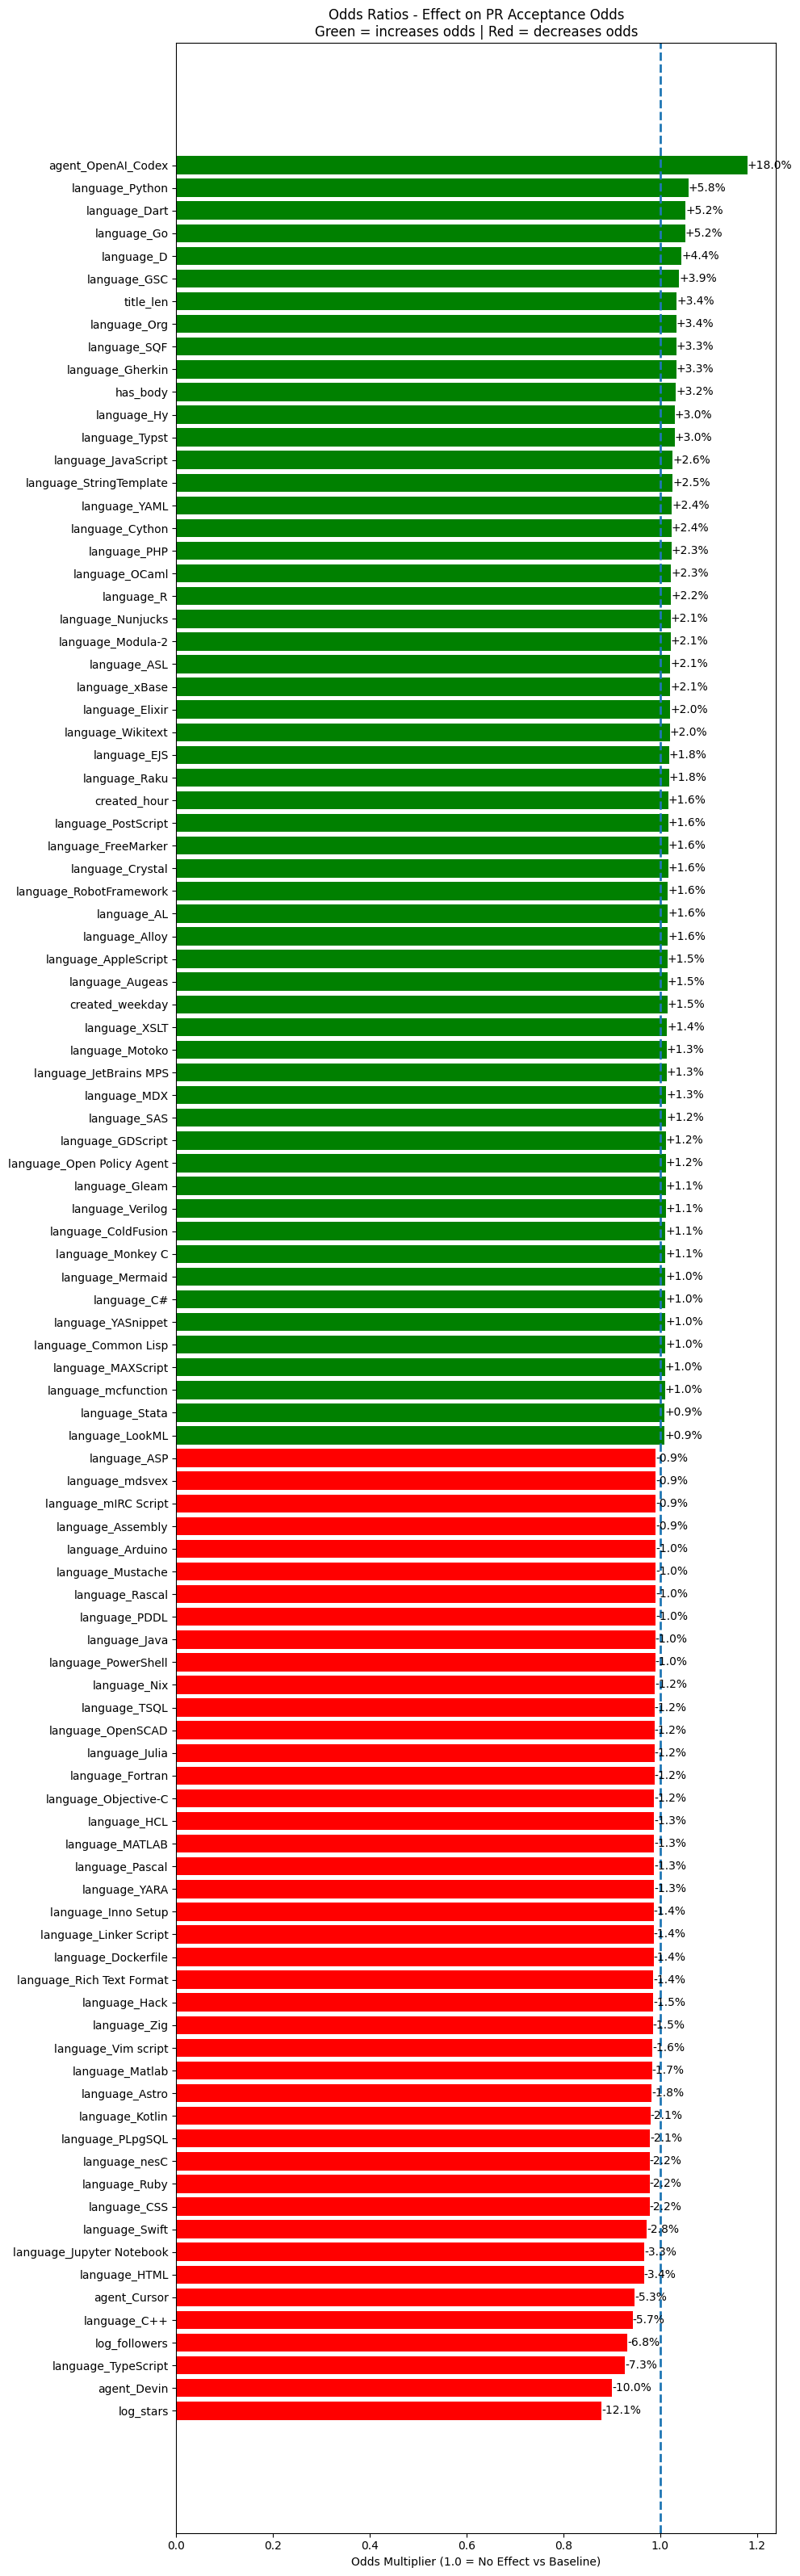

In [31]:
coef = pd.Series(
    lr_models["LR_balanced"].coef_[0],
    index=X.columns
)

TOP_N = 100 #number of item shown

top_idx = coef.abs().sort_values(ascending=False).head(TOP_N).index
coef_top = coef.loc[top_idx].sort_values()

odds = np.exp(coef_top)

colors = ["green" if v > 1 else "red" for v in odds]

plt.figure(figsize=(10,32))
bars = plt.barh(odds.index, odds.values, color=colors)

plt.axvline(1.0, linestyle="--", linewidth=2)

for i, v in enumerate(odds.values):
    pct = (v - 1) * 100
    plt.text(v, i, f"{pct:+.1f}%", va="center")

plt.title("Odds Ratios - Effect on PR Acceptance Odds\nGreen = increases odds | Red = decreases odds")
plt.xlabel("Odds Multiplier (1.0 = No Effect vs Baseline)")
plt.tight_layout()
plt.show()


### Why not SHAP values?
SHAP was not used because the primary model is logistic regression, which is inherently interpretable through coefficients and odds ratios. Tree models were interpreted using built-in feature importance. SHAP would add complexity without providing substantially new interpretive value for this study.



#### Why some agent and language gets higher rating?
- Codex PRs show higher acceptance odds in this dataset

- Agent type remains predictive after controls

- Agent likely acts as a proxy for task patterns

- Python PRs show higher acceptance probability in this dataset

- Language acts as a contextual signal

----------------------------------------------------------------------------------------------------------------------------------------------

#### Why are we finding the BEST F1 threshold?:

Default threshold = 0.50 
but this is not always optimal.

The dataset is imbalanced (accepted PRs likely dominate), and:
- Accuracy becomes misleading
- ROC shows ranking quality
- But threshold controls final decisions

We want best balance of:
- precision (how correct accepted predictions are)
- recall (how many accepted PRs we catch)

F1 = harmonic mean of precision and recall 


Best F1 threshold = best operational decision rule

The **best F1 threshold** gives the best precision-recall balance.

Important:

ROC AUC selects the best model  
F1 threshold selects the best operating point.

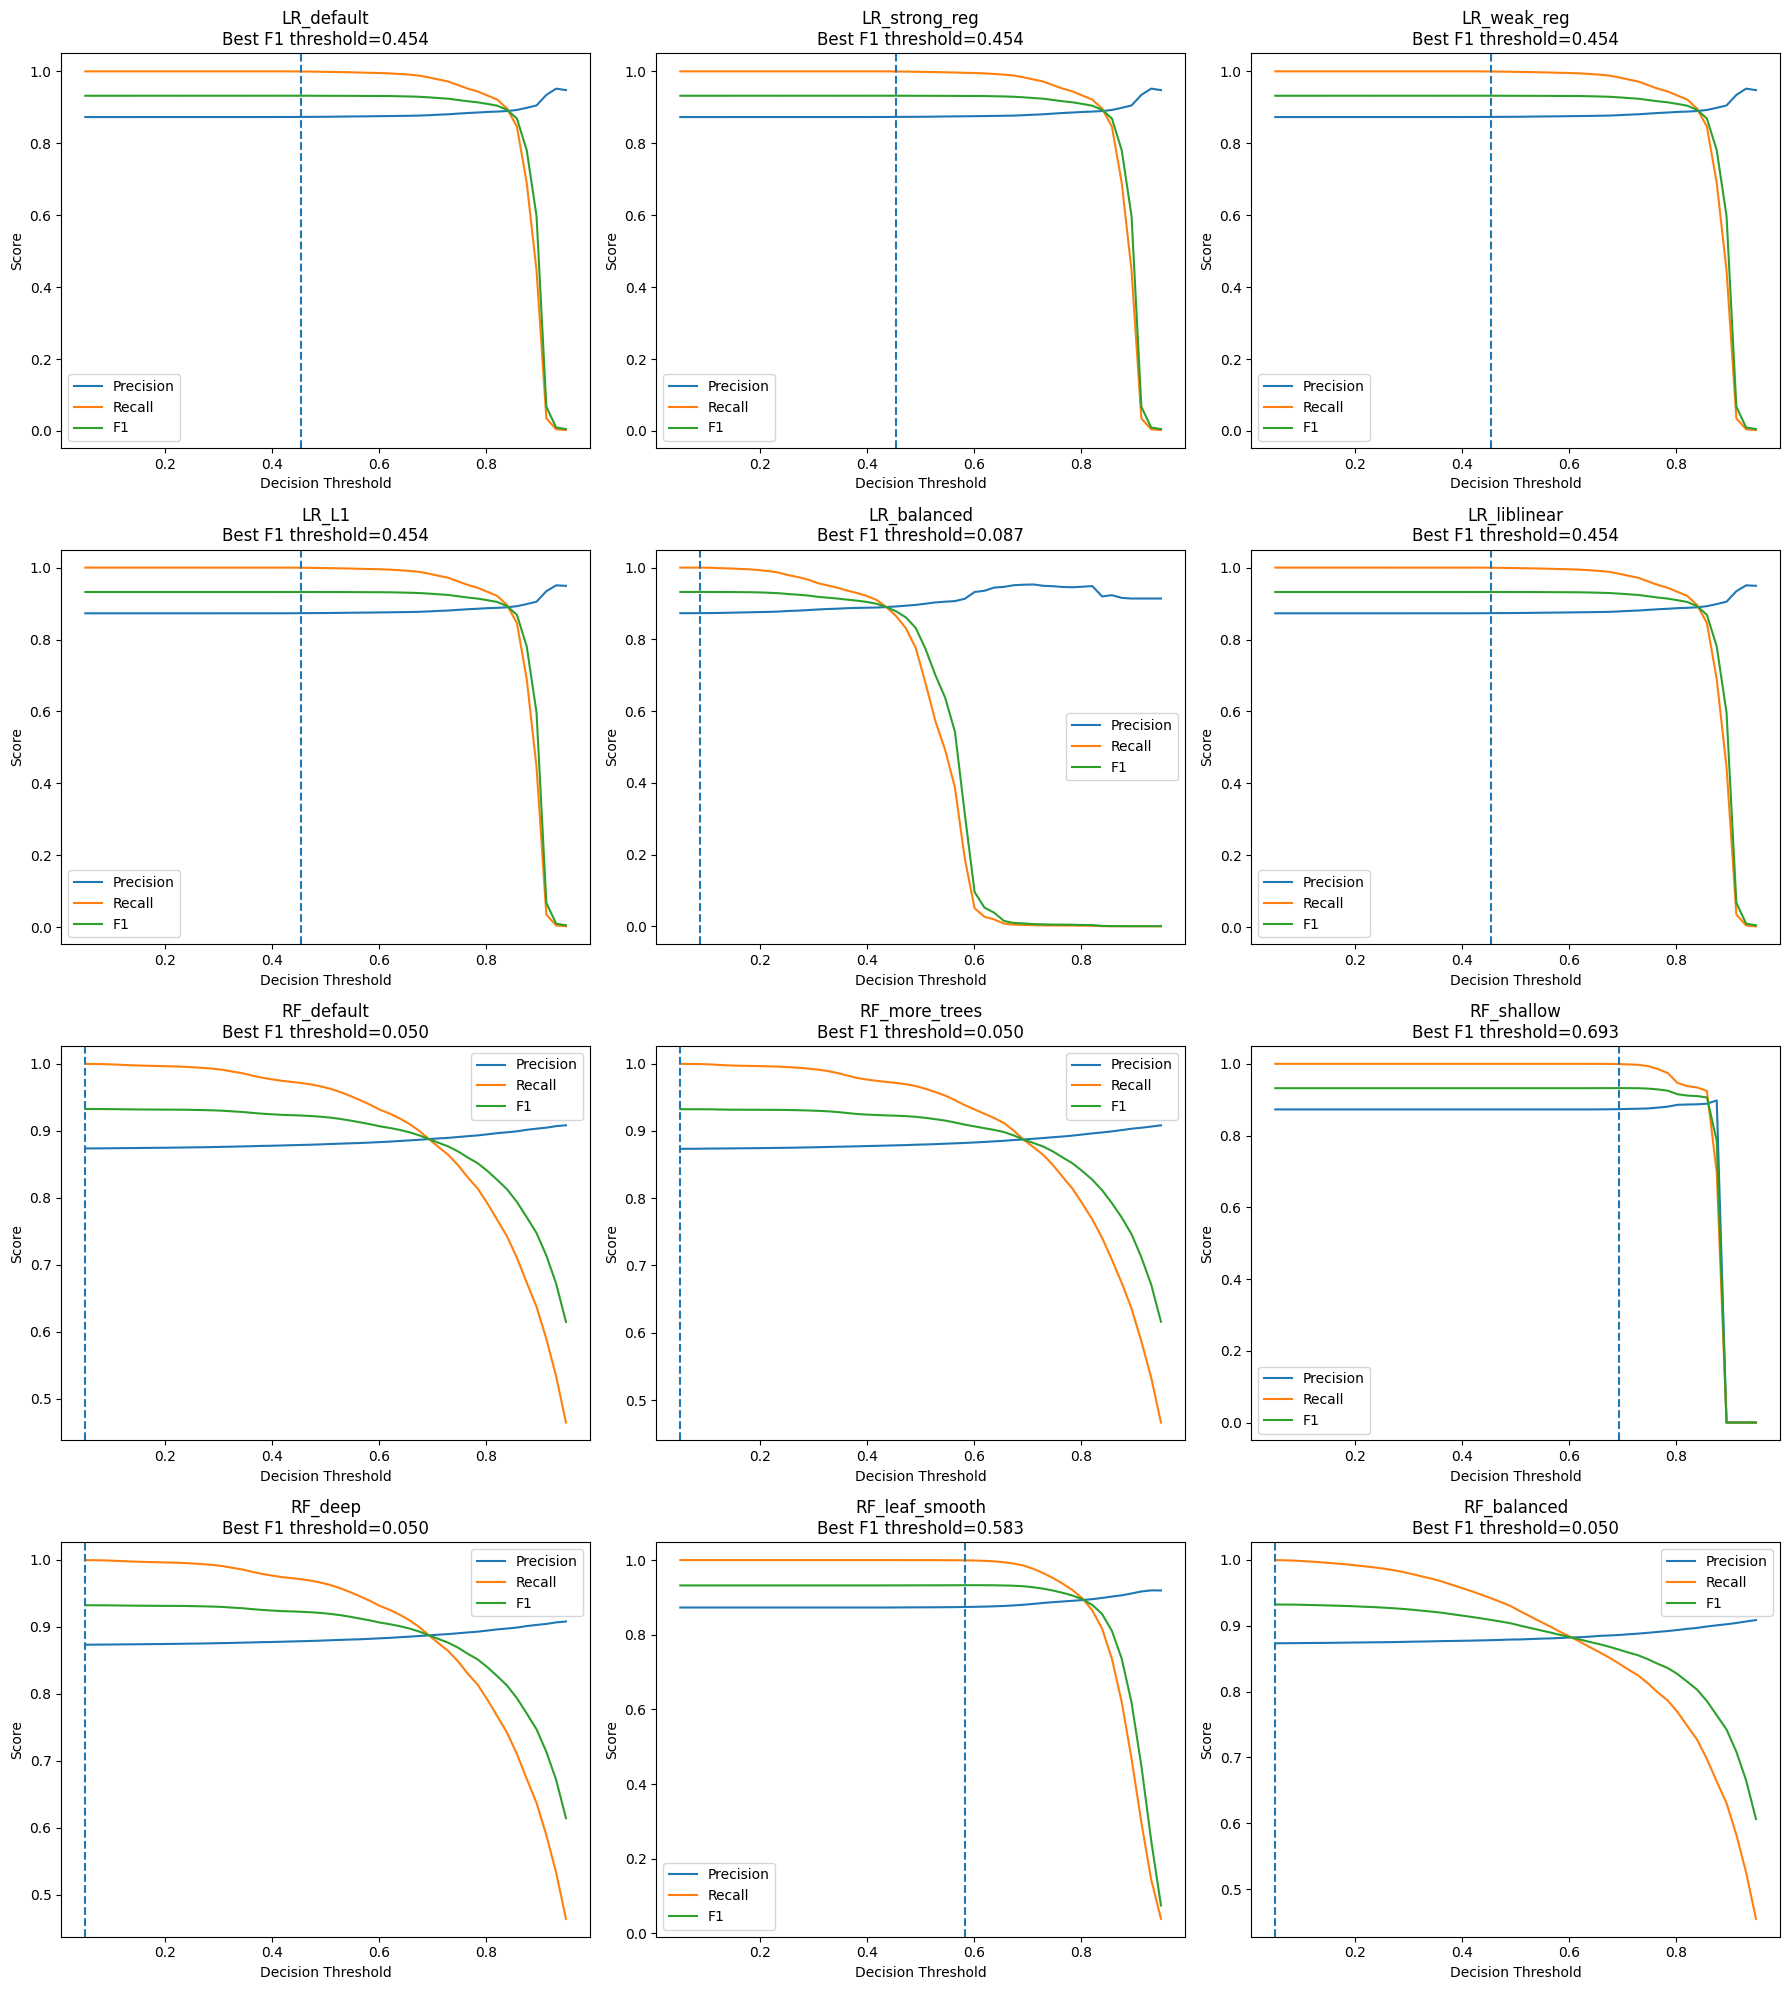

In [32]:
ths = np.linspace(0.05, 0.95, 50)

n_models = len(model_probs)
cols = 3
rows = int(np.ceil(n_models / cols))

fig, axes = plt.subplots(rows, cols, figsize=(18, 5*rows))
axes = axes.flatten()

best_thresholds = {}

for ax, (name, prob) in zip(axes, model_probs.items()):

    precisions = [precision_score(y_test, prob > t, zero_division=0) for t in ths]
    recalls    = [recall_score(y_test, prob > t, zero_division=0) for t in ths]
    f1s        = [f1_score(y_test, prob > t, zero_division=0) for t in ths]

    best_idx = np.argmax(f1s)
    best_t = ths[best_idx]
    best_thresholds[name] = best_t

    ax.plot(ths, precisions, label="Precision")
    ax.plot(ths, recalls, label="Recall")
    ax.plot(ths, f1s, label="F1")

    ax.axvline(best_t, linestyle="--")
    ax.set_title(f"{name}\nBest F1 threshold={best_t:.3f}")
    ax.set_xlabel("Decision Threshold")
    ax.set_ylabel("Score")
    ax.legend()

for i in range(len(model_probs), len(axes)):
    axes[i].axis("off")

plt.tight_layout()
plt.show()


#### Why many LR models show SAME best threshold?

Logistic regression probability ranking is stable across hyperparameters, that means regularization changed magnitude but not ordering. Therefore there is not much difference from changing hyperparameters.


#### Why RF thresholds are very low (0.05 etc.)?

RandomForest gives lower probability scores overall even though its a good PR.
There is also a probability calibration differences of which two models may rank correctly but give very different probability scales.

#### Cross-Validation Stability Check

We perform K-Fold cross validation to measure:

- Score variability
- Model stability
- Sensitivity to data splits

Low variance across folds indicates more reliable performance estimates.


In [33]:
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

lr_best = LogisticRegression(max_iter=1000)

scores = cross_val_score(
    lr_best,
    X_train_scaled,
    y_train,
    cv=cv,
    scoring="roc_auc"
)

print("LR CV ROC AUC scores:", scores)
print("LR CV mean:", scores.mean())


LR CV ROC AUC scores: [0.60719465 0.60599616 0.611807   0.60933532 0.61011979]
LR CV mean: 0.6088905841198099


In [34]:
rf_fast = RandomForestClassifier(
    n_estimators=100,
    max_depth=8,
    random_state=42
)

scores = cross_val_score(
    rf_fast,
    X_train,
    y_train,
    cv=3,
    scoring="roc_auc"
)

print("RF CV ROC AUC:", scores)
print("RF CV mean:", scores.mean())


RF CV ROC AUC: [0.61118298 0.61434495 0.61625575]
RF CV mean: 0.6139278918433912


Random State Stability Check

the smaller the Std dev, the better

In [35]:
states = [1,2,3,4,5]
scores = []

for s in states:
    rf = RandomForestClassifier(n_estimators=150, random_state=s)
    rf.fit(X_train_small, y_train_small)
    prob = rf.predict_proba(X_test)[:,1]
    scores.append(roc_auc_score(y_test, prob))

print("RF stability scores:", scores)
print("Std dev:", np.std(scores))


RF stability scores: [0.6073066558620502, 0.6072361947041496, 0.6070278491812064, 0.6064557929003673, 0.6071557952641394]
Std dev: 0.00030475862184519304


#### Baseline & Bias Robustness Tests

One-hot encoding introduces a baseline category.

We verify that:
- Changing the baseline does not materially change ROC AUC
- Feature importance ranking remains stable
- Model performance is consistent across subgroups

This helps ensure the model is not unfairly dependent on arbitrary encoding choices.


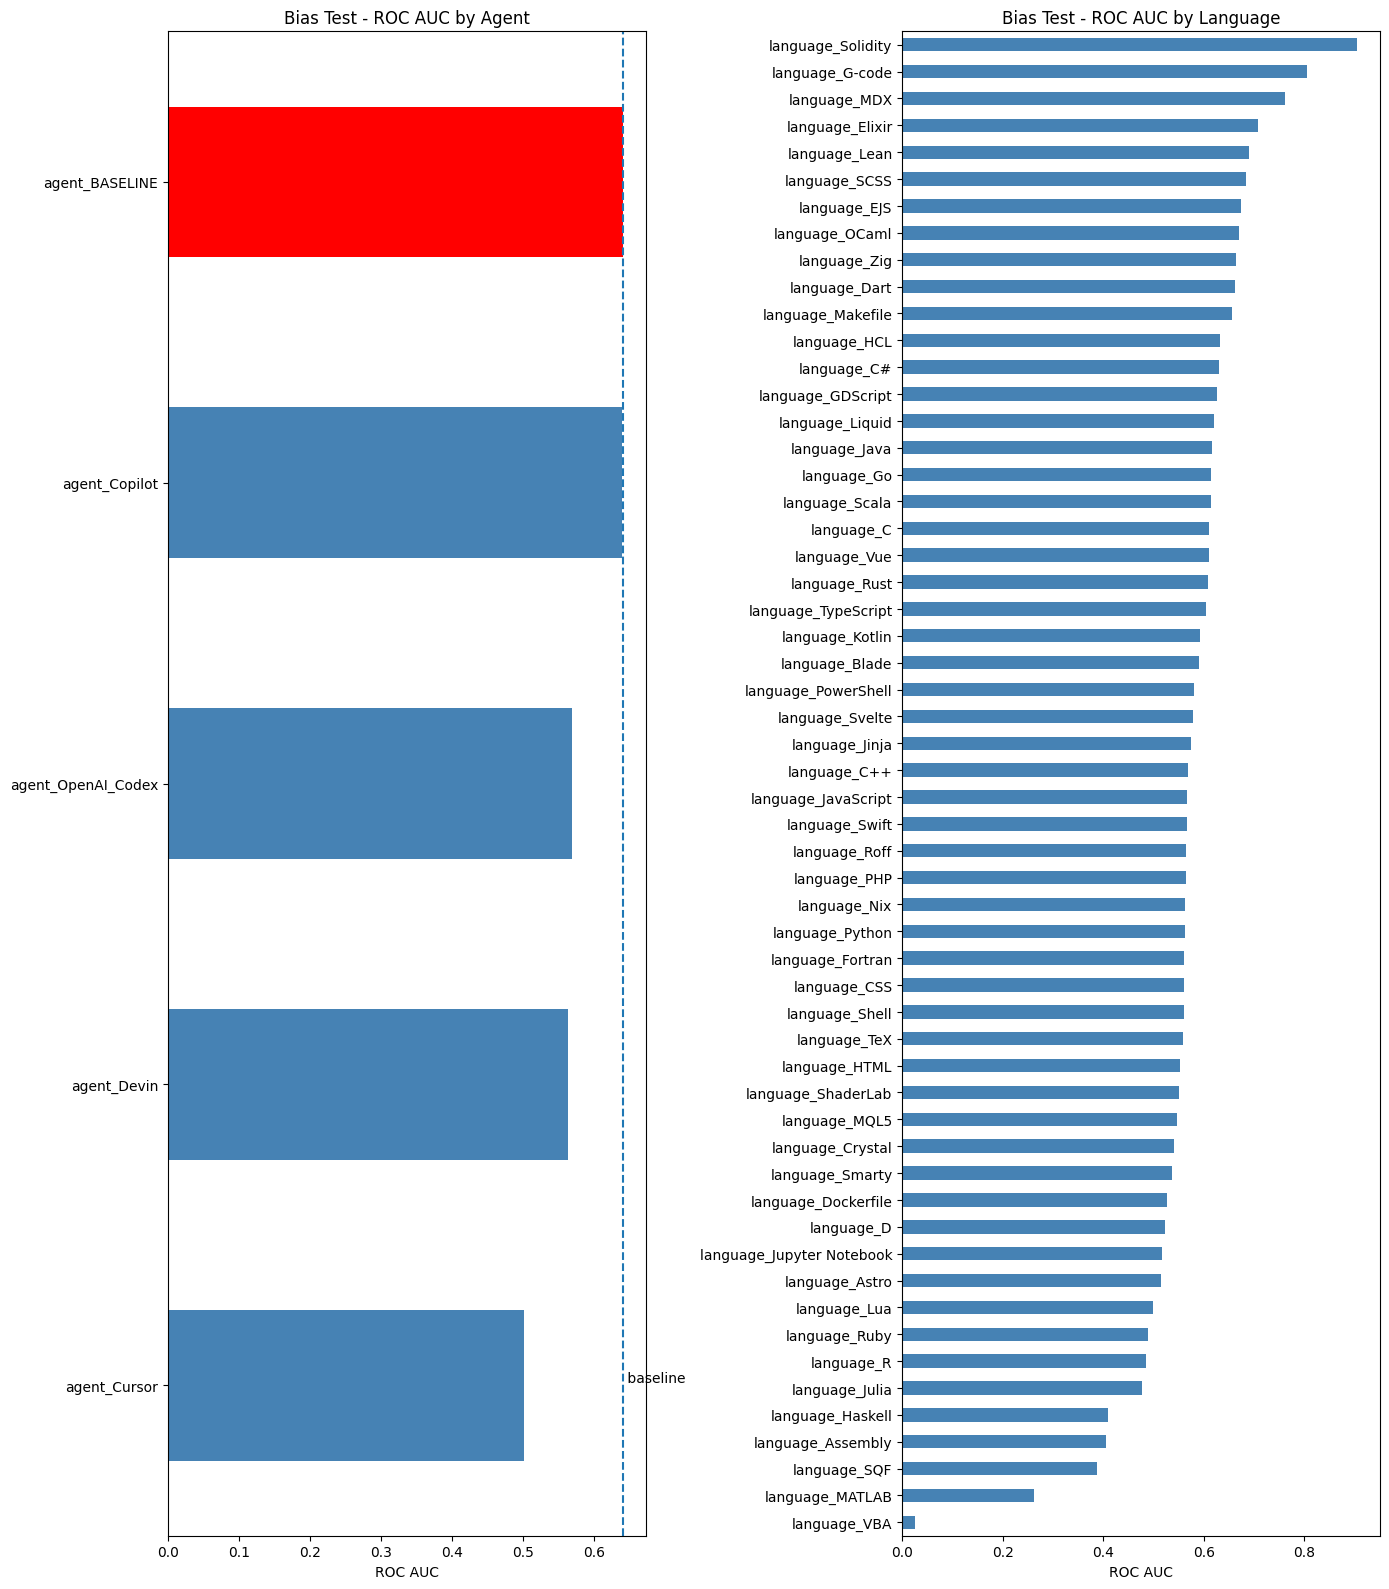

In [ ]:
TOP_K = 150   # <-- change this to control how many shown

test_df = X_test.copy()
test_df["accepted"] = y_test.values
test_df["prob"] = best_lr.predict_proba(X_test_scaled)[:,1]

# AGENT SUBGROUP

agent_cols = [c for c in X.columns if c.startswith("agent_")]
agent_scores = {}

for col in agent_cols:
    mask = test_df[col] == 1
    if mask.sum() > 30: 
        agent_scores[col] = roc_auc_score(
            test_df.loc[mask,"accepted"],
            test_df.loc[mask,"prob"]
        )

baseline_mask = (test_df[agent_cols].sum(axis=1) == 0)
if baseline_mask.sum() > 30:
    agent_scores["agent_BASELINE"] = roc_auc_score(
        test_df.loc[baseline_mask,"accepted"],
        test_df.loc[baseline_mask,"prob"]
    )

agent_perf = pd.Series(agent_scores).sort_values()

agent_top = agent_perf.tail(TOP_K)
if "agent_BASELINE" in agent_perf:
    agent_top["agent_BASELINE"] = agent_perf["agent_BASELINE"]

# LANGUAGE SUBGROUP

lang_cols = [c for c in X.columns if c.startswith("language_")]
lang_scores = {}

for col in lang_cols:
    mask = test_df[col] == 1
    if mask.sum() > 30:
        lang_scores[col] = roc_auc_score(
            test_df.loc[mask,"accepted"],
            test_df.loc[mask,"prob"]
        )

lang_base_mask = (test_df[lang_cols].sum(axis=1) == 0)
if lang_base_mask.sum() > 30:
    lang_scores["language_BASELINE"] = roc_auc_score(
        test_df.loc[lang_base_mask,"accepted"],
        test_df.loc[lang_base_mask,"prob"]
    )

lang_perf = pd.Series(lang_scores).sort_values()

lang_top = lang_perf.tail(TOP_K)
if "language_BASELINE" in lang_perf:
    lang_top["language_BASELINE"] = lang_perf["language_BASELINE"]

# SIDE BY SIDE PLOT

fig, axes = plt.subplots(1,2, figsize=(14,16))

# agent plot
colors = ["red" if i=="agent_BASELINE" else "steelblue"
          for i in agent_top.index]

agent_top.plot.barh(ax=axes[0], color=colors)
axes[0].set_title("Bias Test - ROC AUC by Agent")
axes[0].set_xlabel("ROC AUC")

if "agent_BASELINE" in agent_top:
    axes[0].axvline(agent_top["agent_BASELINE"],
                    linestyle="--")
    axes[0].text(
        agent_top["agent_BASELINE"],
        0,
        " baseline",
        va="bottom"
    )

# language plot
colors = ["red" if i=="language_BASELINE" else "steelblue"
          for i in lang_top.index]

lang_top.plot.barh(ax=axes[1], color=colors)
axes[1].set_title("Bias Test - ROC AUC by Language")
axes[1].set_xlabel("ROC AUC")

if "language_BASELINE" in lang_top:
    axes[1].axvline(lang_top["language_BASELINE"],
                    linestyle="--")
    axes[1].text(
        lang_top["language_BASELINE"],
        0,
        " baseline",
        va="bottom"
    )

plt.tight_layout()
plt.show()


In [ ]:
print("Language baseline AUC:",
      lang_perf.get("language_BASELINE"))
print("Language baseline count:", lang_base_mask.sum()) # language baseline sanity check


Language baseline AUC: None
Language baseline count: 2


#### Why is the baseline language missing?
- The baseline language subgroup shows substantially lower ROC AUC compared to major languages. This reflects small-sample effects rather than model bias toward a specific language, and highlights why subgroup performance reporting is necessary.
- The baseline language subgroup contains only 2 samples in the test split.
ROC AUC is not computed for groups with fewer than 30 samples to avoid unstable or misleading estimates.
Therefore the language baseline does not appear in the subgroup bias plot.

The model demonstrates higher ROC AUC within Solidity PRs. This likely reflects stronger separability of acceptance signals within that subgroup rather than systematic model bias. Subgroup sample size and feature distribution differences should be considered when interpreting this result.

#### Alternate Baseline Test

Alternate baseline categories used:
agent: ['OpenAI_Codex']
language: ['xBase']
Original ROC AUC: 0.6081148538176633
Alternate baseline ROC AUC: 0.6081305865853383


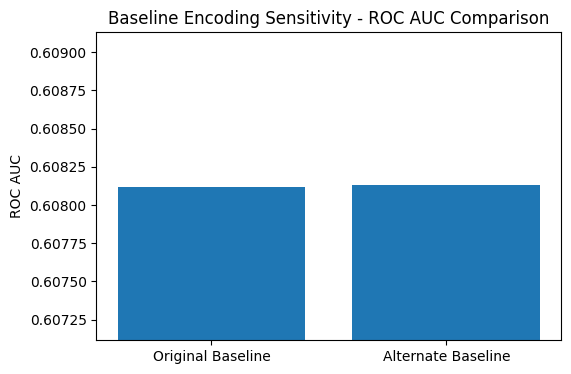

In [ ]:
df_alt_before_dummies = df_before_dummies.copy()

df_alt_before_dummies["agent"] = pd.Categorical(
    df_alt_before_dummies["agent"],
    categories=sorted(df_alt_before_dummies["agent"].unique(), reverse=True) # reverse the category so we get different baseline
)

df_alt_before_dummies["language"] = pd.Categorical(
    df_alt_before_dummies["language"],
    categories=sorted(df_alt_before_dummies["language"].unique(), reverse=True)
)

df_alt_after_dummies = pd.get_dummies(
    df_alt_before_dummies,
    columns=["agent","language"],
    drop_first=True
)

# Detect alternate baselines

alt_baseline_info = find_baselines(
    df_alt_before_dummies,
    df_alt_after_dummies,
    ["agent","language"]
)

print("Alternate baseline categories used:")
for k,v in alt_baseline_info.items():
    print(f"{k}: {v}")

# Build alternate feature matrix

X_alt = df_alt_after_dummies.drop(columns=["accepted"])
y_alt = df_alt_after_dummies["accepted"]

X_train_a, X_test_a, y_train_a, y_test_a = train_test_split(
    X_alt,
    y_alt,
    test_size=0.2,
    stratify=y_alt,   # ← important fix
    random_state=42
)

scaler_a = StandardScaler()
X_train_a = scaler_a.fit_transform(X_train_a)
X_test_a = scaler_a.transform(X_test_a)

# Train alternate model

model_alt = LogisticRegression(
    max_iter=1000,
    class_weight="balanced"
)

model_alt.fit(X_train_a, y_train_a)

prob_alt = model_alt.predict_proba(X_test_a)[:,1]

# comparison

orig_auc = roc_auc_score(
    y_test,
    lr_models["LR_balanced"].predict_proba(X_test_scaled)[:,1]
)

alt_auc = roc_auc_score(y_test_a, prob_alt)

print("Original ROC AUC:", orig_auc)
print("Alternate baseline ROC AUC:", alt_auc)

plt.figure(figsize=(6,4))
plt.bar(
    ["Original Baseline", "Alternate Baseline"],
    [orig_auc, alt_auc]
)

plt.ylabel("ROC AUC")
plt.title("Baseline Encoding Sensitivity - ROC AUC Comparison")

# zoom for visibility
plt.ylim(min(orig_auc, alt_auc)-0.001,
         max(orig_auc, alt_auc)+0.001)

plt.show()


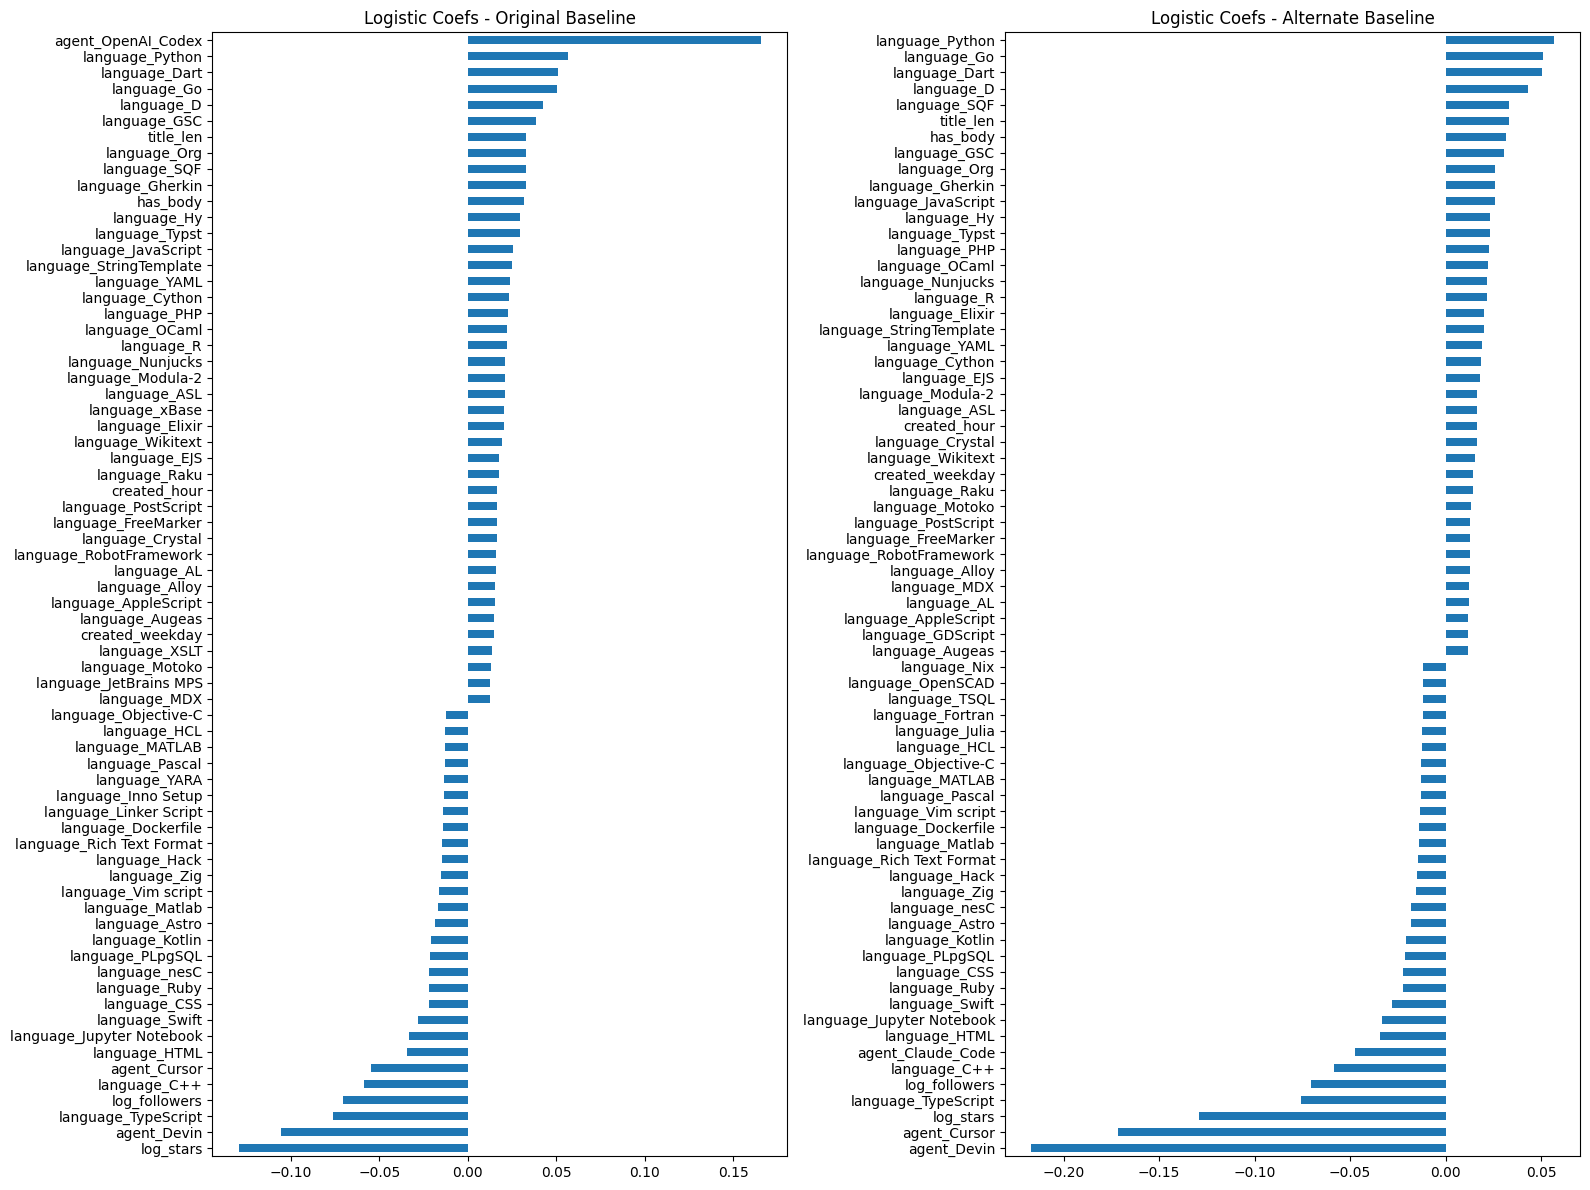

In [55]:
orig_model = lr_models["LR_balanced"]
orig_coef = pd.Series(orig_model.coef_[0], index=X.columns)

alt_coef = pd.Series(model_alt.coef_[0], index=X_alt.columns)

TOPK = 70 # <-- change this to control how many shown

orig_top = orig_coef.abs().sort_values(ascending=False).head(TOPK).index
alt_top = alt_coef.abs().sort_values(ascending=False).head(TOPK).index

orig_plot = orig_coef.loc[orig_top].sort_values()
alt_plot = alt_coef.loc[alt_top].sort_values()

fig, axes = plt.subplots(1,2, figsize=(16,12))

orig_plot.plot.barh(ax=axes[0])
axes[0].set_title("Logistic Coefs - Original Baseline")

alt_plot.plot.barh(ax=axes[1])
axes[1].set_title("Logistic Coefs - Alternate Baseline")

plt.tight_layout()
plt.show()


In [39]:
rf_alt = RandomForestClassifier(
    n_estimators=150,
    random_state=42
)

rf_alt.fit(X_train_a, y_train_a)


,"n_estimators n_estimators: int, default=100The number of trees in the forest... versionchanged:: 0.22 The default value of ``n_estimators`` changed from 10 to 100 in 0.22.",150
,"criterion criterion: {""gini"", ""entropy"", ""log_loss""}, default=""gini""The function to measure the quality of a split. Supported criteria are""gini"" for the Gini impurity and ""log_loss"" and ""entropy"" both for theShannon information gain, see :ref:`tree_mathematical_formulation`.Note: This parameter is tree-specific.",'gini'
,"max_depth max_depth: int, default=NoneThe maximum depth of the tree. If None, then nodes are expanded untilall leaves are pure or until all leaves contain less thanmin_samples_split samples.",None
,"min_samples_split min_samples_split: int or float, default=2The minimum number of samples required to split an internal node:- If int, then consider `min_samples_split` as the minimum number.- If float, then `min_samples_split` is a fraction and `ceil(min_samples_split * n_samples)` are the minimum number of samples for each split... versionchanged:: 0.18 Added float values for fractions.",2
,"min_samples_leaf min_samples_leaf: int or float, default=1The minimum number of samples required to be at a leaf node.A split point at any depth will only be considered if it leaves atleast ``min_samples_leaf`` training samples in each of the left andright branches. This may have the effect of smoothing the model,especially in regression.- If int, then consider `min_samples_leaf` as the minimum number.- If float, then `min_samples_leaf` is a fraction and `ceil(min_samples_leaf * n_samples)` are the minimum number of samples for each node... versionchanged:: 0.18 Added float values for fractions.",1
,"min_weight_fraction_leaf min_weight_fraction_leaf: float, default=0.0The minimum weighted fraction of the sum total of weights (of allthe input samples) required to be at a leaf node. Samples haveequal weight when sample_weight is not provided.",0.0
,"max_features max_features: {""sqrt"", ""log2"", None}, int or float, default=""sqrt""The number of features to consider when looking for the best split:- If int, then consider `max_features` features at each split.- If float, then `max_features` is a fraction and `max(1, int(max_features * n_features_in_))` features are considered at each split.- If ""sqrt"", then `max_features=sqrt(n_features)`.- If ""log2"", then `max_features=log2(n_features)`.- If None, then `max_features=n_features`... versionchanged:: 1.1 The default of `max_features` changed from `""auto""` to `""sqrt""`.Note: the search for a split does not stop until at least onevalid partition of the node samples is found, even if it requires toeffectively inspect more than ``max_features`` features.",'sqrt'
,"max_leaf_nodes max_leaf_nodes: int, default=NoneGrow trees with ``max_leaf_nodes`` in best-first fashion.Best nodes are defined as relative reduction in impurity.If None then unlimited number of leaf nodes.",None
,"min_impurity_decrease min_impurity_decrease: float, default=0.0A node will be split if this split induces a decrease of the impuritygreater than or equal to this value.The weighted impurity decrease equation is the following:: N_t / N * (impurity - N_t_R / N_t * right_impurity - N_t_L / N_t * left_impurity)where ``N`` is the total number of samples, ``N_t`` is the number ofsamples at the current node, ``N_t_L`` is the number of samples in theleft child, and ``N_t_R`` is the number of samples in the right child.``N``, ``N_t``, ``N_t_R`` and ``N_t_L`` all refer to the weighted sum,if ``sample_weight`` is passed... versionadded:: 0.19",0.0
,"bootstrap bootstrap: bool, default=TrueWhether bootstrap samples are used when building trees. If False, thewhole dataset is used to build each tree.",True
,"oob_score oob_score: bool or callable, default=FalseWhether to use out-of-bag samples to estimate the generalization score.By default, :func:`~sklearn.metrics.accuracy_score` is used.Provide a callable with signature `metric

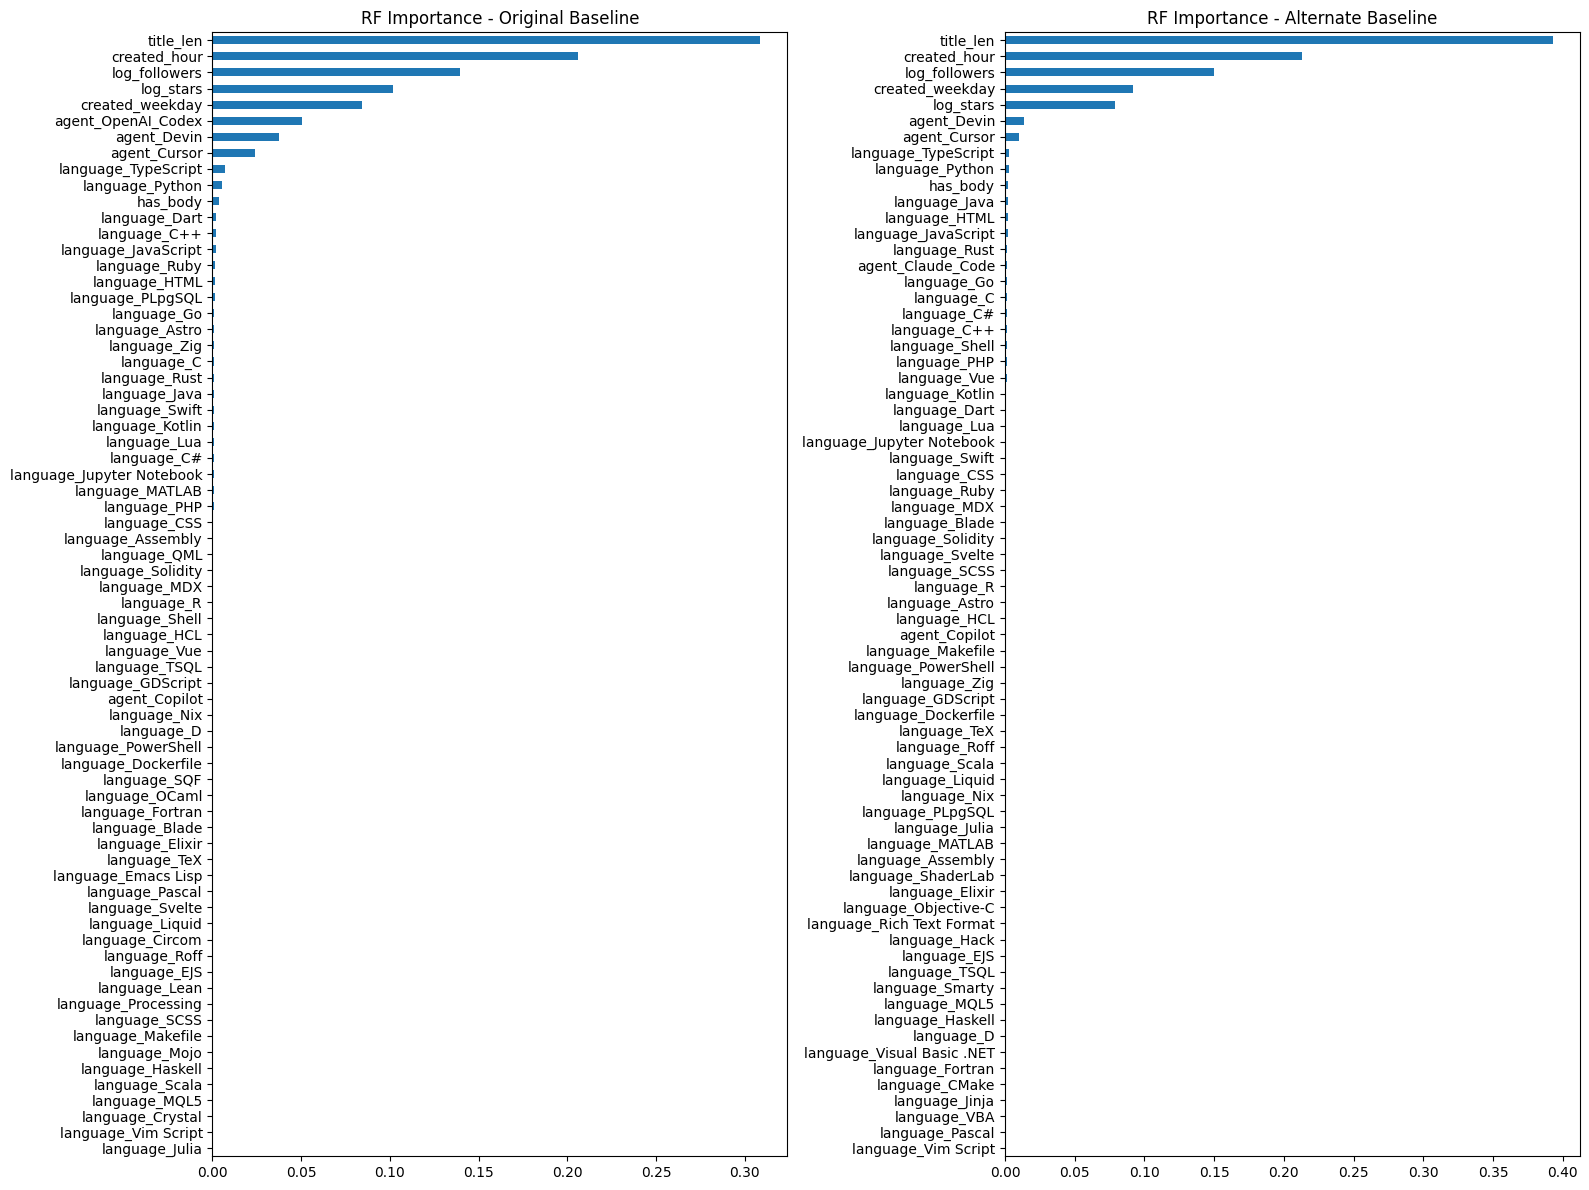

In [40]:

orig_rf = rf_models["RF_leaf_smooth"]   # or your best RF
orig_imp = pd.Series(orig_rf.feature_importances_, index=X.columns)

alt_imp = pd.Series(rf_alt.feature_importances_, index=X_alt.columns)

TOPK = 70 # <-- change this to control how many shown

orig_plot = orig_imp.sort_values(ascending=False).head(TOPK).sort_values()
alt_plot = alt_imp.sort_values(ascending=False).head(TOPK).sort_values()

fig, axes = plt.subplots(1,2, figsize=(16,12))

orig_plot.plot.barh(ax=axes[0])
axes[0].set_title("RF Importance - Original Baseline")

alt_plot.plot.barh(ax=axes[1])
axes[1].set_title("RF Importance - Alternate Baseline")

plt.tight_layout()
plt.show()


#### Feature Order Stability Test

Rank correlation: 0.76691356554153
Top-100 overlap: 0.81


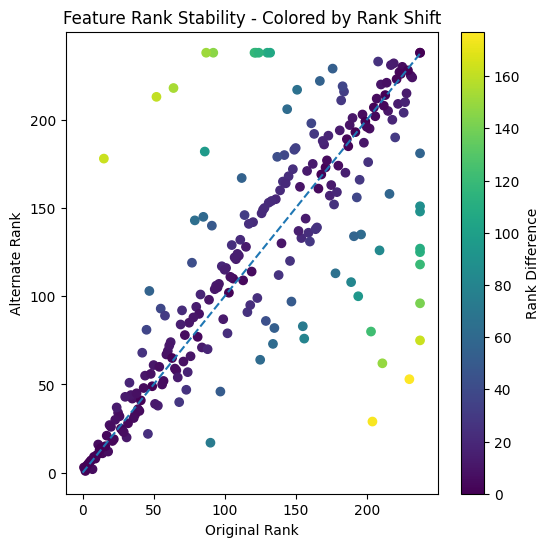

In [ ]:
# original best LR
orig_model = lr_models["LR_balanced"]
orig_coef = pd.Series(orig_model.coef_[0], index=X.columns)

# alternate model coefficients
alt_coef = pd.Series(model_alt.coef_[0], index=X_alt.columns)

common = orig_coef.index.intersection(alt_coef.index)

orig_rank = orig_coef.loc[common].abs().rank(ascending=False)
alt_rank = alt_coef.loc[common].abs().rank(ascending=False)

rank_df = pd.DataFrame({
    "orig_rank": orig_rank,
    "alt_rank": alt_rank
})

corr = rank_df.corr().iloc[0,1]
print("Rank correlation:", corr)

K = 100 # <-- change this to control how many shown

top_orig = set(orig_coef.abs().sort_values(ascending=False).head(K).index)
top_alt = set(alt_coef.abs().sort_values(ascending=False).head(K).index)

overlap = len(top_orig & top_alt) / K

print(f"Top-{K} overlap:", overlap)

rank_df["diff"] = (rank_df["orig_rank"] - rank_df["alt_rank"]).abs()

plt.figure(figsize=(6,6))
plt.scatter(
    rank_df["orig_rank"],
    rank_df["alt_rank"],
    c=rank_df["diff"],
)

plt.colorbar(label="Rank Difference")
plt.plot([0, rank_df.max().max()],
         [0, rank_df.max().max()],
         linestyle="--")

plt.xlabel("Original Rank")
plt.ylabel("Alternate Rank")
plt.title("Feature Rank Stability - Colored by Rank Shift")
plt.show()


## Limitations

##### **1. No Code Content or Diff Data** 
The dataset does not include the actual code changes, commit diffs, or modified files inside each PR. As a result, the model cannot directly measure code quality, complexity, or correctness.

This means the model predicts acceptance based on context signals (such as repository popularity, contributor signals, and PR structure) rather than technical code quality itself. A PR could be accepted or rejected for code reasons that are not visible to the model.

##### **2. Limited Text Information**

Although PR titles and bodies exist, most PR bodies are missing and titles are often very short. Because of this, advanced text modeling (such as NLP features) was not used. Adding NLP would likely add noise instead of reliable signal with this dataset quality.

##### **3. Category Imbalance and Sparse Subgroups**

Some agents and programming languages appear much more frequently than others. Rare categories produce unstable subgroup metrics and may appear artificially high or low due to small sample size.

Bias tests were performed with minimum subgroup size thresholds, but rare-category instability remains a limitation.

# Conclusion

This study compared multiple model families and hyperparameter variants for PR acceptance prediction.

Key findings:

- Logistic Regression and Random Forest achieved similar ROC AUC (~0.60 range)
- Hyperparameter variation changed coefficient magnitude but not feature ranking
- Threshold tuning significantly affects recall vs precision tradeoff
- Baseline encoding choice had minimal effect on ROC AUC
- Feature importance remained stable across alternate baselines
- Subgroup testing revealed performance variation driven mostly by sample size

Overall, results indicate moderate predictive signal with stable ranking behavior and acceptable robustness across modeling choices.